Тестовое задание №2  **Стажёр в команду Core ML **

---



Выполнила: Софья Марцинович

---



**Формулировка задания**

Цель — научиться вычислять эмбеддинги текстов.
Необходимо сделать модель машинного обучения, вычисляющую эмбеддинги текста (векторное представление фиксированной длины), используя готовые наработки либо обучив её самостоятельно. Вид векторного представления может быть произвольным, но каждый из эмбеддингов не должен содержать более 1000 чисел.

После чего нужно по датасету вопросов Quora Question Pairs (https://www.kaggle.com/c/quora-question-pairs/) обучить модель, возвращающую вероятность похожести пар вопросов только по паре их эмбеддингов. Модель должна выдавать на тестовой выборке в публичном лидерборде kaggle logloss не больше 0,5. 

В качестве результата необходимо предоставить код обучения моделей и формирования итогового файла с результатами, код вычисления эмбеддингов, а также указать ссылку на свой профиль в kaggle. Кроме logloss будет учитываться сложность и эффективность представленного решения.
[Ссылка]
Quora Question Pairs
https://www.kaggle.com/c/quora-question-pairs/

---





**Подготовка к работе**

In [49]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()






ЗАГРУЗКА ДАННЫХ

In [50]:

df_train=pd.read_csv('../input/train.csv')


Делаем копию датафреймов (на всякий случай)

In [51]:
df_train_copy = df_train


Проверка на наличие нулевых строк:

In [52]:
print(df_train_copy.isnull().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


  Список выше подтверждает наличие нулевых строк. 
  Заменяем их на "пустые" строки, чтобы далее не возникло ошибок на этапе преобразования в нижний регистр. 

In [53]:
train = df_train.fillna('empty')

Видим, что теперь нулевых строк нет:

In [54]:
print(train.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


Размерность датафрейма:

In [55]:
#Чтобы не тратить время при отладке решения, сокращаем датафрейм до 40000 строк: 
#df = train[0:40000]
df = train
df.shape

(404290, 6)

ПРОСМОТР ДАННЫХ

Выведем для просмотра первые строки датафрейма и некоторую дополнительную информацию о содержимом дадафрейма:

In [56]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Смотрим разметку, сравниваем количество дубликатов/не дубликатов:

In [58]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

Строим word cloud - графическое представление самых распространенных в датафрейме слов:

(-0.5, 999.5, 999.5, -0.5)

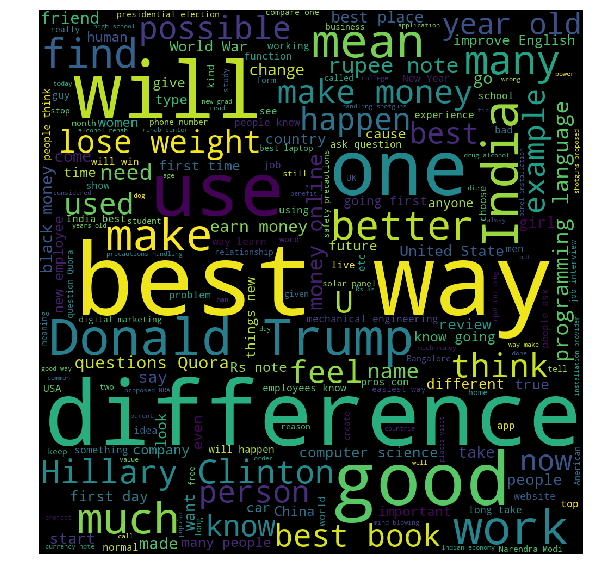

In [59]:
train_qs = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)

from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=1000).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

Наиболее распространенными являются такие слова как "best way", "difference", "use", "make", "good", "one" и др. Действительно, именно эти слова пользователи употребляют чаще других в формулировках вопросов. Также можно проследить основную тематику вопросов: ключевые слова "Donald Trump", "India" и др.

Рассмотрим несколько пар вопросов:

In [60]:
print("Not duplicate:")
print(df.question1[0])
print(df.question2[0])
print()
print("Not duplicate:")
print(df.question1[1])
print(df.question2[1])
print()
print("Is duplicate:")
print(df.question1[5])
print(df.question2[5])

Not duplicate:
What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

Not duplicate:
What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

Is duplicate:
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


1. Первая пара вопросов выглядит похожей по набору используемых слов, но смысл вопросов разный. 
2. В формулировках используются разные слова, вопросы несут разный смысл. 
3. В паре вопросов используется разный набор слов, но смысл вопросов одинаковый (очень близкий). 


НЮАНСЫ НАПИСАНИЯ, ПУНКТУАЦИЯ

Изучим подробнее написание вопросов:

In [61]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


ПОДГОТОВКА ТЕКСТА

Делаем текст максимально единообразным:
1.  Удаляем слова, не несущие смысл (т.н. "stopwords").
2.  Удаляем все знаки препинания и одиночные символы. 
3.  Все слова преобразовываем в нижний регистр.
4.  Применяем к словам алгоритм стемминга.

In [62]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re  # For preprocessing


def review_to_wordlist(review, remove_stopwords=True):
    #Приводим слова к нижнему регистру, разделяем
    words = review.lower().split()

    #(по умолчанию) удаляем слова из списка "stopwords"
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    review_text = " ".join(words)

    #Очищаем текст от знаков препинания
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
    review_text = re.sub(r"\'s", " 's ", review_text)
    review_text = re.sub(r"\'ve", " 've ", review_text)
    review_text = re.sub(r"n\'t", " 't ", review_text)
    review_text = re.sub(r"\'re", " 're ", review_text)
    review_text = re.sub(r"\'d", " 'd ", review_text)
    review_text = re.sub(r"\'ll", " 'll ", review_text)
    review_text = re.sub(r",", " ", review_text)
    review_text = re.sub(r"\.", " ", review_text)
    review_text = re.sub(r"!", " ", review_text)
    review_text = re.sub(r"\(", " ( ", review_text)
    review_text = re.sub(r"\)", " ) ", review_text)
    review_text = re.sub(r"\?", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    
    words = review_text.split()
    
    #"Обрезаем" слова до начальной формы, оставляя только их основы
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    
    review_text = " ".join(stemmed_words)
    
    #Возвращаем список слов
    return(review_text)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


Функция для преобразования вопросов. 
Показывает прогресс выполнения операции.

In [63]:
def process_questions(question_list, questions, question_list_name):
# function to transform questions and display progress
    for question in questions:
        question_list.append(review_to_wordlist(question))
        if len(question_list) % 10000 == 0:
            progress = len(question_list)/len(df) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

Выполняем преобразование вопросов:

In [64]:
questions1 = []     
process_questions(questions1, df.question1, "questions1")
print()
questions2 = []     
process_questions(questions2, df.question2, "questions2")

questions1 is 2.5% complete.
questions1 is 4.9% complete.
questions1 is 7.4% complete.
questions1 is 9.9% complete.
questions1 is 12.4% complete.
questions1 is 14.8% complete.
questions1 is 17.3% complete.
questions1 is 19.8% complete.
questions1 is 22.3% complete.
questions1 is 24.7% complete.
questions1 is 27.2% complete.
questions1 is 29.7% complete.
questions1 is 32.2% complete.
questions1 is 34.6% complete.
questions1 is 37.1% complete.
questions1 is 39.6% complete.
questions1 is 42.0% complete.
questions1 is 44.5% complete.
questions1 is 47.0% complete.
questions1 is 49.5% complete.
questions1 is 51.9% complete.
questions1 is 54.4% complete.
questions1 is 56.9% complete.
questions1 is 59.4% complete.
questions1 is 61.8% complete.
questions1 is 64.3% complete.
questions1 is 66.8% complete.
questions1 is 69.3% complete.
questions1 is 71.7% complete.
questions1 is 74.2% complete.
questions1 is 76.7% complete.
questions1 is 79.2% complete.
questions1 is 81.6% complete.
questions1 is 

Посмотрим, как теперь выглядят наши вопросы (пары вопросов):

In [65]:
# первые пять пар
for i in range(5):
    print(questions1[i])
    print(questions2[i])
    print()

step step guid invest share market india
step step guid invest share market

stori kohinoor ( koh i noor ) diamond
would happen indian govern stole kohinoor ( koh i noor ) diamond back

increas speed internet connect use vpn
internet speed increas hack dns

mental lone solv it
find remaind math 23 24 math divid 24 23

one dissolv water quik sugar salt methan carbon di oxid
fish would surviv salt water





---

ВЗЯТО ОТСЮДА:  https://www.kaggle.com/liananapalkova/simply-about-word2vec/log

ПРЕОБРАЗОВАНИЕ СЛОВ В ВЕКТОРЫ

Для дальнейшего преобразования вопросов используем метод Word2Vec - один из многих методов вычисления эмбеддингов текстов. 

Обучение (training) Word2Vec:
Данная модель представляет из себя двуслойную нейронную сеть. Для ее обучения требуется подстроить под себя формат представления данных, полученных от Quora. 
На основе колонки "question1" построим список из списков (list of lists). Для этого используем функцию "simple_preprocess" (GenSim).

In [66]:
#df=pd.read_csv('train.csv')
#df = df[0:40000]

In [67]:
import gensim

Строим "list of lists":

In [68]:
def read_questions(row,column_name):
    return gensim.utils.simple_preprocess(str(row[column_name]).encode('utf-8'))
    
documents = []
for index, row in df.iterrows():
    documents.append(read_questions(row,"question1"))
    if row["is_duplicate"] == 0:
        documents.append(read_questions(row,"question2"))

Проверим результат:

In [69]:
print("List of lists. Let's confirm: ", type(documents), " of ", type(documents[0]))

List of lists. Let's confirm:  <class 'list'>  of  <class 'list'>


Метод Word2Vec поможет нам извлечь все уникальные слова из вложенных списков (sub-lists), из этих слов будет сформирован словарь уникальных слов.

In [70]:
model = gensim.models.Word2Vec(size=150, window=10, min_count=2, sg=1, workers=10)
model.build_vocab(documents)  #подготовка словаря уникальных слов

Теперь, когда словарь сформирован и в метод Word2Vec внесены все необходимые поправки, мы можем приступить к обучению модели. Используем функцию train:

In [71]:
model.train(sentences=documents, total_examples=len(documents), epochs=model.iter)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(25464447, 35144510)

Вот так выглядят слова (токены) сложенные в "model.wv.vocab".
Для сокращенного списка train (40000 строк) получаем 16339 оригинальных слов, для полного списка - 47336

В качестве эксперимента можем изменить количество слов в модели (count<10) и посмотреть, как от этого изменится длина предложения:

In [72]:
word_vectors = model.wv
count = 0
for word in word_vectors.vocab:
    if count<10:
        print(word)
        count += 1
    else:
        break

what
is
the
step
by
guide
to
invest
in
share


Просмотр размерности:

In [73]:
len(word_vectors.vocab)

47336

Вектор для токена лежит в  "model.wv".  Он превышает длину самого слова.  Это его окружение, мы сами задавали длину вектора, определяя параметр "size" равным 150.

Параметр "size": означает размерность векторов слов. Он определяет количество токенов, используемых для представления каждого слова. Если набор данных большой, то и размер должен быть больше. Это вопрос тюнинга.

Отсюда: https://www.kaggle.com/liananapalkova/simply-about-word2vec/log

Посмотрим на размерность одного из векторов:

In [74]:
vector = model.wv["immigration"]
len(vector)

150

Выведем на экран сам вектор:

In [75]:
vector

array([-5.69009185e-01,  2.57416487e-01, -3.74462776e-04,  3.49747866e-01,
       -6.55420899e-01,  4.87106815e-02, -2.22677290e-01,  2.17127025e-01,
       -3.05326521e-01,  3.12490538e-02, -7.35389441e-02,  8.14477950e-02,
        2.15379268e-01, -2.10969105e-01, -4.53931034e-01, -2.77885407e-01,
        2.50461757e-01,  6.11256957e-01, -5.43889225e-01,  1.09077193e-01,
        9.58990678e-02, -4.87789720e-01, -2.47840211e-02,  7.05181360e-02,
       -3.52795213e-01,  2.51602102e-02,  5.15484996e-02, -2.07724929e-01,
       -4.97120887e-01, -6.08797550e-01, -2.27208510e-02, -1.03379697e-01,
        4.72684316e-02,  1.71633855e-01, -1.80305377e-01,  2.33934775e-01,
       -4.82692599e-01,  8.04795623e-01, -1.25261813e-01, -5.71503639e-01,
        4.15491253e-01,  1.09395586e-01,  9.76314023e-02,  1.58996824e-02,
       -4.16754633e-01, -4.75829951e-02, -3.89833689e-01,  2.84537435e-01,
       -8.47956836e-02, -3.50622803e-01,  1.79781720e-01,  3.10311168e-01,
       -1.93345413e-01,  

АНАЛИЗ РЕЗУЛЬТАТОВ

(С) This first example shows a simple case of looking up top 5 words similar to the word "phone". To do this, I will call the "most_similar" function and provide the word "phone" as the positive example. This returns the top 5 similar words: "mobile", "phones", "smartphone", "iphone" and "device".
Посмотрим, насколько алгоритм способен оценить похожесть слов. Для примера выберем слово "phone". 
Используем функцию "most_similar". 

In [76]:
w1 = "phone"
model.wv.most_similar(positive=w1, topn=5)

[('mobile', 0.7695169448852539),
 ('phones', 0.7507720589637756),
 ('smartphone', 0.7447254657745361),
 ('device', 0.7259187698364258),
 ('cellphone', 0.7249593734741211)]

Получаем топ 5 самых близких по занчению слов: "mobile", "phones", "smartphone", "iphone", "device".

(Для случая с укороченными данными (40000 строк) результаты не такие точные, но также показательные: "mobile", "imei", "device", "sms", "verizon")

Похожий пример из статьи на Хабре (https://habr.com/ru/company/ods/blog/329410/):


In [77]:
model.wv.most_similar(positive=['open', 'data','science','best'])

[('springboard', 0.7633179426193237),
 ('telematics', 0.7398841977119446),
 ('beginers', 0.7385652661323547),
 ('oportunities', 0.7379692196846008),
 ('engenearing', 0.7372825741767883),
 ('econometric', 0.7369651794433594),
 ('sciece', 0.7332606315612793),
 ('univerisity', 0.73233562707901),
 ('karumanchi', 0.7319096326828003),
 ('statistician', 0.7318680882453918)]

Подсчет точности, используем метрику log_loss:

In [78]:
from sklearn.metrics import log_loss
p = df_train['is_duplicate'].mean()

print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('../input/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)

sub.head()

Predicted score: 0.6585273839844354


,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


Таким образом получаем, что значение log_loss равно 0.369198.